In [ ]:
import pathlib2 as pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import tokenize

from langdetect import detect, DetectorFactory

import joblib
from optuna import Trial, create_study


random_state=313
DetectorFactory.seed = random_state

In [2]:
datapath=pathlib.Path.cwd().joinpath('lens_org_data_files')
datafiles=[x for x in datapath.iterdir()]
models_path=pathlib.Path.cwd().joinpath('models')

In [16]:
def clean_text(text):
    clean = re.sub('<jats:[^>]*>', '', text)  # Entfernt alle jats Tags
    return clean

In [3]:
dfs=[]
for file in datafiles:
    df=pd.read_csv(file)
    dfs.append(df)

data=pd.concat(dfs,ignore_index=True)
data=data.dropna(subset=['Title', 'Abstract'])

C:\Users\lekle\AppData\Local\Temp\ipykernel_27884\856187700.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)
C:\Users\lekle\AppData\Local\Temp\ipykernel_27884\856187700.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)
C:\Users\lekle\AppData\Local\Temp\ipykernel_27884\856187700.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)
C:\Users\lekle\AppData\Local\Temp\ipykernel_27884\856187700.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)
C:\Users\lekle\AppData\Local\Temp\ipykernel_27884\856187700.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)
C:\Users\lekle\AppData\Local\Temp\ipykernel_27884\

In [4]:
data.columns

Index(['Lens ID', 'Title', 'Date Published', 'Publication Year',
       'Publication Type', 'Source Title', 'ISSNs', 'Publisher',
       'Source Country', 'Author/s', 'Abstract', 'Volume', 'Issue Number',
       'Start Page', 'End Page', 'Fields of Study', 'Keywords', 'MeSH Terms',
       'Chemicals', 'Funding', 'Source URLs', 'External URL', 'PMID', 'DOI',
       'Microsoft Academic ID', 'PMCID', 'Citing Patents Count', 'References',
       'Citing Works Count', 'Is Open Access', 'Open Access License',
       'Open Access Colour'],
      dtype='object')

In [5]:
print(data.Title.isna().sum())
print(data.Abstract.isna().sum())

0
0


In [7]:
data.Abstract[0]

'<jats:p>Day-ahead solar irradiance forecasting is carried out using data from a tropical environment, Singapore. The performance of the weather research and forecasting (WRF) model is evaluated. We explore various combinations of physics configuration setups in the WRF model and propose a setup for the tropical regions. The WRF model is benchmarked using persistence and two seasonal time series models, namely, the exponential smoothing (ETS) and seasonal autoregressive integrated moving average (SARIMA) models. It is shown that the WRF model outperforms the SARIMA model and achieves accuracies comparable with persistence and ETS models. Persistence, ETS, and WRF models have relative root mean square errors (rRMSE) of about 55–57%. Furthermore, we find that by combining the forecasting outputs of WRF and ETS models, errors can be reduced to 49%.</jats:p>'

In [8]:
languages=[]
for x in data.Title:
    try:
        l=detect(x)
    except:
        l=False
    languages.append(l)
data['title_languages']=languages

languages=[]
for x in data.Abstract:
    try:
        l=detect(x)
    except:
        l=False
    languages.append(l)
data['abstract_languages']=languages


In [9]:
# data.title_languages.value_counts()

In [12]:
data=data[(data['title_languages']=='en') & (data['abstract_languages']=='en')]
len(data)

242040

In [ ]:
data.Title.head(5)

0    Day-Ahead Solar Irradiance Forecasting in a Tr...
1    PORTABLE GREEN POWER GENERATION BASED ON HYBRI...
2    Assessment of a falling solid particle receive...
3    Reduction of the plasmonic absorption in the n...
4    Boron-Doped Silicon Diatom Frustules as a Phot...
Name: Title, dtype: object

In [13]:
print(len(data))
print(len(data['Source Country'].unique()))
# data_sourceCountry_valueCounts=data['Source Country'].value_counts()
data_sourceCountry_valueCounts=data[data.groupby('Source Country')['Source Country'].transform('count')>1000]
print(len(data_sourceCountry_valueCounts['Source Country'].value_counts()))
data_sourceCountry_valueCounts['Source Country'].value_counts()

242040
80
8


Source Country
United Kingdom    40811
United States     32451
Germany           17973
Switzerland       12466
Netherlands        8749
China              1598
Egypt              1187
India              1074
Name: count, dtype: int64

In [17]:
data['Abstract']=data.Abstract.apply(clean_text)
data.to_csv("cleaned_data.csv",sep=';')

In [19]:
data.Abstract.head()

0     Day-ahead solar irradiance forecasting is carr...
2     An advanced computational fluid dynamics (CFD)...
4     An effective solar-powered silicon device for ...
5     Abstract In this study, an isolated microgrid ...
11    Thermal and electrical analysis of a linear pa...
Name: Abstract, dtype: object

In [3]:
data=pd.read_csv("cleaned_data/cleaned_data.csv",sep=';')
data.head()

C:\Users\lekle\AppData\Local\Temp\ipykernel_452\719415488.py:1: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("cleaned_data/cleaned_data.csv",sep=';')


,Unnamed: 0,Lens ID,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,...,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count,Is Open Access,Open Access License,Open Access Colour,title_languages,abstract_languages
0,0,000-008-268-360-004,Day-Ahead Solar Irradiance Forecasting in a Tr...,2015-07-27,2015,journal article,Journal of Solar Energy Engineering,01996231; 15288986,ASME International,United States,...,2131632891,NaN,0,001-815-086-488-477; 007-447-979-011-061; 025-...,33,False,NaN,NaN,en,en
1,2,000-042-629-788-452,Assessment of a falling solid particle receive...,NaN,2015,journal article,Solar Energy,0038092x,Elsevier BV,United Kingdom,...,2067658121,NaN,0,002-994-869-371-657; 005-360-904-860-363; 008-...,62,True,NaN,green,en,en
2,4,000-062-946-383-801,Boron-Doped Silicon Diatom Frustules as a Phot...,2015-07-30,2015,journal article,ACS applied materials & interfaces,19448252; 19448244,American Chemical Society (ACS),United States,...,2410807451,NaN,0,004-049-858-705-806; 007-090-004-757-278; 011-...,26,False,NaN,NaN,en,en
3,5,000-063-768-273-718,Renewable energy management through microgrid ...,NaN,2015,journal article,Energy Reports,23524847,Elsevier BV,United Kingdom,...,1193286937,NaN,0,004-077-674-704-399; 005-081-834-054-355; 011-...,79,True,"CC BY, CC BY-NC-ND",gold,en,en
4,11,000-138-869-752-834,Thermal and electrical analysis of a linear pa...,2015-12-01,2015,NaN,NaN,NaN,NaN,NaN,...,3210564331,NaN,0,NaN,0,False,NaN,NaN,en,en


In [46]:
stopwords=stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_vectors = tfidf_vectorizer.fit_transform(data['Title'])
tfidf_vectors.shape

(254447, 20235)

In [49]:
nmf_text_model = NMF(n_components=50, random_state=random_state) # n_components: number of topics
W_text_matrix = nmf_text_model.fit_transform(tfidf_vectors)
H_text_matrix = nmf_text_model.components_
np.info(W_text_matrix)

class:  ndarray
shape:  (254447, 50)
strides:  (400, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x19a03c21040
byteorder:  little
byteswap:  False
type: float64


In [50]:
np.info(H_text_matrix) 

class:  ndarray
shape:  (50, 20235)
strides:  (8, 400)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x19a00347040
byteorder:  little
byteswap:  False
type: float64


In [51]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))
            
display_topics(nmf_text_model, tfidf_vectorizer.get_feature_names_out())


Topic 00
  system (35.60)
  integrated (2.44)
  monitoring (2.11)
  heating (1.62)
  cooling (1.53)

Topic 01
  perovskite (13.82)
  cells (9.89)
  stable (1.65)
  stability (1.64)
  tandem (1.26)

Topic 02
  sub (35.25)
  co (2.09)
  tio (1.46)
  cu (1.06)
  scp (0.97)

Topic 03
  energy (16.94)
  renewable (7.58)
  sources (2.04)
  harvesting (1.30)
  management (1.28)

Topic 04
  performance (24.07)
  evaluation (3.86)
  effect (2.41)
  collector (1.24)
  experimental (1.16)

Topic 05
  power (28.13)
  plant (5.19)
  plants (3.26)
  quality (1.75)
  concentrated (1.36)

Topic 06
  based (27.93)
  iot (1.40)
  monitoring (0.88)
  method (0.87)
  mppt (0.80)

Topic 07
  photovoltaic (30.46)
  modules (2.41)
  module (1.87)
  panels (1.68)
  devices (0.98)

Topic 08
  thermal (23.37)
  collector (2.64)
  experimental (1.32)
  collectors (1.19)
  parabolic (1.11)

Topic 09
  hydrogen (12.22)
  production (11.13)
  evolution (2.44)
  photocatalytic (2.25)
  green (2.09)

Topic 10
  grid

In [52]:
# Find out how “big” the topics are, i.e., how many documents could be assigned mainly to each topic. 
# This can be calculated using the document-topic matrix and 
# summing the individual topic contributions over all documents.
# Normalizing them with the total sum and multiplying by 100 gives a percentage value:

print(W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0)

[0.92107735 2.94957144 2.36491615 5.84892933 1.63464385 3.19710793
 1.88503729 2.18190544 1.33419815 1.03283192 1.17287122 2.54532112
 1.66821773 1.10668354 2.95490498 1.51343868 0.81979635 1.88301162
 1.66227445 1.67413562 0.64616082 1.3672007  1.57183605 1.19470891
 1.50398656 1.35327762 1.16429827 1.93705616 1.75977276 1.70760468
 3.24866825 1.10330043 1.57233496 1.89152997 1.55426629 2.01973403
 1.26409713 2.17841097 3.25422294 1.80040284 1.96372267 2.12486678
 2.03421557 2.62630775 2.35875261 2.34304014 2.31855733 2.96462467
 3.93373652 2.88843145]


In [60]:
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 5

# Dokument-Topic-Zuordnung anzeigen
# for doc_idx, topic_dist in enumerate(W_text_matrix):
#     print(f"Dokument {doc_idx}:")
#     print(" ".join([f"Topic {i}: {topic_dist[i]:.2f}" for i in np.argsort(topic_dist)[::-1]]))

In [56]:
# Gensim Dictionary und Corpus erstellen
texts = [doc.split() for doc in data.Title.to_list()]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Topics in Gensim-Format umwandeln
topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in H_text_matrix]

# Kohärenzmodell erstellen
coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Topic Kohärenz: {coherence_score:.2f}")

Topic Kohärenz: 0.72


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


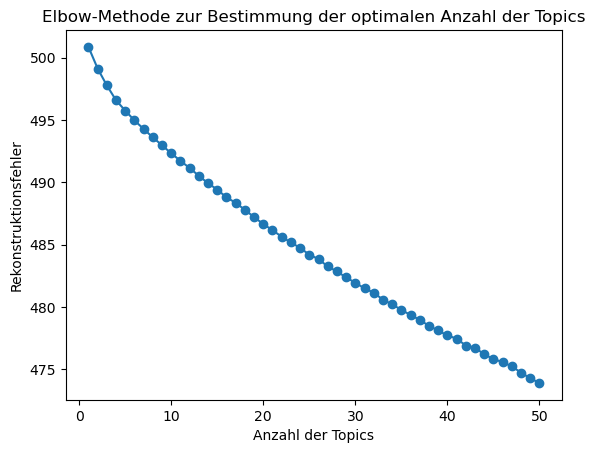

In [59]:
X = tfidf_vectors
# Elbow-Methode
errors = []
for n_topics in range(1, 51):
    nmf = NMF(n_components=n_topics, random_state=random_state)
    W = nmf.fit_transform(X)
    H = nmf.components_
    reconstruction_error = nmf.reconstruction_err_
    errors.append(reconstruction_error)

plt.plot(range(1, 51), errors, marker='o')
plt.xlabel('Anzahl der Topics')
plt.ylabel('Rekonstruktionsfehler')
plt.title('Elbow-Methode zur Bestimmung der optimalen Anzahl der Topics')
plt.show()

In [4]:
stopwords2=stopwords.words('english')
stopwords3=list(STOPWORDS)

In [4]:

studyname='topicmodeling_nmf_titles'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')


def inst_tfidf(trial:Trial)->TfidfVectorizer:
    params={
        'stop_words':'english',
        'tokenizer':tokenize,
        # 'max_features':trial.suggest_categorical('max_features',[None,1000,5000,10000])
        'max_df':trial.suggest_float('max_df',0.4,1),
        'min_df':trial.suggest_int('min_df',10,100)
    }
    return TfidfVectorizer(**params)

def inst_nmf(trial:Trial)->NMF:
    params={
        'random_state':random_state,
        'n_components':trial.suggest_categorical('n_components',[5,10,25,50,100])
    }
    return NMF(**params)
def inst_pipe_nmf(trial:Trial)->Pipeline:
    pipeline=Pipeline([
        ('tfidf',inst_tfidf(trial)),
        ('nmf',inst_nmf(trial))
    ])
    return pipeline
def objective(trial:Trial,x:pd.DataFrame)->float:
    model=inst_pipe_nmf(trial)
    # print(type(model))
    fitmodel=model.fit(x)
    W_text_matrix = fitmodel.transform(x)
    H_text_matrix = fitmodel.named_steps['nmf'].components_
    feature_names = fitmodel.named_steps['tfidf'].get_feature_names_out()
    n_top_words = 5
    texts=[doc.split() for doc in x.to_list()]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in H_text_matrix]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score


storage=thismodelpath.joinpath(f"{studyname}.db")
if storage.exists():
    storage.unlink()
else:
    print("No sqlite db found")

study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
study.optimize(lambda trial: objective(trial,data['Title']),n_trials=20,n_jobs=1,show_progress_bar=True)
joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

model=inst_pipe_nmf(study.best_trial)
fitpipe=model.fit(data['Title'])
joblib.dump(fitpipe,thismodelpath.joinpath(f'{studyname}.pkl').as_posix())

No sqlite db found


[I 2025-03-11 18:32:50,038] A new study created in RDB with name: topicmodeling_nmf_titles


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:34:23,456] Trial 0 finished with value: 0.7029450436635895 and parameters: {'max_df': 0.8178862223292064, 'min_df': 93, 'n_components': 50}. Best is trial 0 with value: 0.7029450436635895.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:35:35,046] Trial 1 finished with value: 0.7278457935562976 and parameters: {'max_df': 0.6119607005333083, 'min_df': 75, 'n_components': 25}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:36:19,031] Trial 2 finished with value: 0.6438110504021215 and parameters: {'max_df': 0.9731897169322492, 'min_df': 84, 'n_components': 5}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:42:29,173] Trial 3 finished with value: 0.6622884063328577 and parameters: {'max_df': 0.4065786592070851, 'min_df': 27, 'n_components': 100}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:44:00,099] Trial 4 finished with value: 0.6991335345687973 and parameters: {'max_df': 0.8992522367842861, 'min_df': 51, 'n_components': 50}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:45:22,302] Trial 5 finished with value: 0.6895846564771714 and parameters: {'max_df': 0.8035330556846705, 'min_df': 11, 'n_components': 50}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:49:27,216] Trial 6 finished with value: 0.660486794900957 and parameters: {'max_df': 0.6731090869334164, 'min_df': 11, 'n_components': 100}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:50:11,287] Trial 7 finished with value: 0.6644665588057275 and parameters: {'max_df': 0.4485585058088167, 'min_df': 18, 'n_components': 5}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:51:03,506] Trial 8 finished with value: 0.721951134734044 and parameters: {'max_df': 0.5822125096181309, 'min_df': 85, 'n_components': 10}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:54:23,916] Trial 9 finished with value: 0.6542992136346717 and parameters: {'max_df': 0.8556329368608442, 'min_df': 95, 'n_components': 100}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:55:47,832] Trial 10 finished with value: 0.7173229180968935 and parameters: {'max_df': 0.5832039910229289, 'min_df': 65, 'n_components': 25}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[I 2025-03-11 18:56:44,694] Trial 11 finished with value: 0.721951134734044 and parameters: {'max_df': 0.5686162775255873, 'min_df': 73, 'n_components': 10}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:57:43,385] Trial 12 finished with value: 0.7103202709450162 and parameters: {'max_df': 0.6697753899408245, 'min_df': 57, 'n_components': 25}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:58:34,912] Trial 13 finished with value: 0.721951134734044 and parameters: {'max_df': 0.5414244262888096, 'min_df': 78, 'n_components': 10}. Best is trial 1 with value: 0.7278457935562976.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 18:59:42,626] Trial 14 finished with value: 0.743404348926301 and parameters: {'max_df': 0.48841695822571024, 'min_df': 41, 'n_components': 25}. Best is trial 14 with value: 0.743404348926301.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 19:00:59,902] Trial 15 finished with value: 0.7065082778999127 and parameters: {'max_df': 0.47333421352658056, 'min_df': 39, 'n_components': 25}. Best is trial 14 with value: 0.743404348926301.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 19:02:08,019] Trial 16 finished with value: 0.743404348926301 and parameters: {'max_df': 0.741132540472343, 'min_df': 41, 'n_components': 25}. Best is trial 14 with value: 0.743404348926301.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 19:03:23,503] Trial 17 finished with value: 0.7065082778999127 and parameters: {'max_df': 0.7394351747191222, 'min_df': 39, 'n_components': 25}. Best is trial 14 with value: 0.743404348926301.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 19:04:31,300] Trial 18 finished with value: 0.743404348926301 and parameters: {'max_df': 0.7386566516845466, 'min_df': 41, 'n_components': 25}. Best is trial 14 with value: 0.743404348926301.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 19:05:36,816] Trial 19 finished with value: 0.7036152732183409 and parameters: {'max_df': 0.7405750315800548, 'min_df': 29, 'n_components': 25}. Best is trial 14 with value: 0.743404348926301.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['c:/Users/lekle/Projects_Code/HA_TextAnalytics/models/topicmodeling_nmf_titles/topicmodeling_nmf_titles.pkl']

In [4]:
studyname='topicmodeling_nmf_abstracts'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')


def inst_tfidf(trial:Trial)->TfidfVectorizer:
    params={
        'stop_words': 'english',#trial.suggest_categorical('stop_words',['english',stopwords.words('english'),list(STOPWORDS)]),
        'tokenizer':tokenize,
        # 'max_features':trial.suggest_categorical('max_features',[None,1000,5000,10000])
        'max_df':trial.suggest_float('max_df',0.4,1),
        'min_df':trial.suggest_int('min_df',10,100)
    }
    return TfidfVectorizer(**params)

def inst_nmf(trial:Trial)->NMF:
    params={
        'random_state':random_state,
        'n_components':trial.suggest_categorical('n_components',[5,10,25,50,100])
    }
    return NMF(**params)
def inst_pipe_nmf(trial:Trial)->Pipeline:
    pipeline=Pipeline([
        ('tfidf',inst_tfidf(trial)),
        ('nmf',inst_nmf(trial))
    ])
    return pipeline

def objective(trial:Trial,x:pd.DataFrame)->float:
    model=inst_pipe_nmf(trial)
    fitmodel=model.fit(x)
    W_text_matrix = fitmodel.transform(x)
    H_text_matrix = fitmodel.named_steps['nmf'].components_
    feature_names = fitmodel.named_steps['tfidf'].get_feature_names_out()
    n_top_words = 5
    texts=[doc.split() for doc in x.to_list()]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in H_text_matrix]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score


storage=thismodelpath.joinpath(f"{studyname}.db")
if storage.exists():
    storage.unlink()
else:
    print("No sqlite db found")

study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
study.optimize(lambda trial: objective(trial,data['Abstract']),n_trials=20,n_jobs=1,show_progress_bar=True)
joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

model=inst_pipe_nmf(study.best_trial)
fitpipe=model.fit(data['Abstract'])
joblib.dump(fitpipe,thismodelpath.joinpath(f'{studyname}.pkl').as_posix())

No sqlite db found


[I 2025-03-11 20:12:12,459] A new study created in RDB with name: topicmodeling_nmf_abstracts


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 20:16:45,667] Trial 0 finished with value: 0.5644235863390562 and parameters: {'max_df': 0.9669399524872131, 'min_df': 88, 'n_components': 10}. Best is trial 0 with value: 0.5644235863390562.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 20:29:03,780] Trial 1 finished with value: 0.6518322585651621 and parameters: {'max_df': 0.690679068069564, 'min_df': 77, 'n_components': 100}. Best is trial 1 with value: 0.6518322585651621.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 20:33:25,775] Trial 2 finished with value: 0.5421689048935451 and parameters: {'max_df': 0.7962189261361021, 'min_df': 25, 'n_components': 5}. Best is trial 1 with value: 0.6518322585651621.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[I 2025-03-11 20:38:45,594] Trial 3 finished with value: 0.6249558682174178 and parameters: {'max_df': 0.8798423500993653, 'min_df': 61, 'n_components': 25}. Best is trial 1 with value: 0.6518322585651621.


c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[W 2025-03-11 20:42:59,704] Trial 4 failed with parameters: {'max_df': 0.8193345405623665, 'min_df': 89, 'n_components': 100} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\lekle\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\lekle\AppData\Local\Temp\ipykernel_452\1727404965.py", line 57, in <lambda>
    study.optimize(lambda trial: objective(trial,data['Abstract']),n_trials=20,n_jobs=1,show_progress_bar=True)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lekle\AppData\Local\Temp\ipykernel_452\1727404965.py", line 34, in objective
    fitmodel=model.fit(x)
             ^^^^^^^^^^^^
  File "c:\Users\lekle\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

KeyboardInterrupt: 

# LSA

In [ ]:

studyname='topicmodeling_lsa_titles'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')


def inst_tfidf(trial:Trial)->TfidfVectorizer:
    params={
        'stop_words':'english',
        'tokenizer':tokenize,
        # 'max_features':trial.suggest_categorical('max_features',[None,1000,5000,10000])
        'max_df':trial.suggest_float('max_df',0.4,1),
        'min_df':trial.suggest_int('min_df',10,100)
    }
    return TfidfVectorizer(**params)

def inst_lsa(trial:Trial)->TruncatedSVD:
    params={
        'random_state':random_state,
        'n_components':trial.suggest_categorical('n_components',[5,10,25,50,100])
    }
    return TruncatedSVD(**params)
def inst_pipe_lsa(trial:Trial)->Pipeline:
    pipeline=Pipeline([
        ('tfidf',inst_tfidf(trial)),
        ('nmf',inst_lsa(trial))
    ])
    return pipeline
def objective(trial:Trial,x:pd.DataFrame)->float:
    model=inst_pipe_lsa(trial)
    # print(type(model))
    fitmodel=model.fit(x)
    W_text_matrix = fitmodel.transform(x)
    H_text_matrix = fitmodel.named_steps['nmf'].components_
    feature_names = fitmodel.named_steps['tfidf'].get_feature_names_out()
    n_top_words = 5
    texts=[doc.split() for doc in x.to_list()]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in H_text_matrix]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score


storage=thismodelpath.joinpath(f"{studyname}.db")
if storage.exists():
    storage.unlink()
else:
    print("No sqlite db found")

study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
study.optimize(lambda trial: objective(trial,data['Title']),n_trials=20,n_jobs=1,show_progress_bar=True)
joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

model=inst_pipe_lsa(study.best_trial)
fitpipe=model.fit(data['Title'])
joblib.dump(fitpipe,thismodelpath.joinpath(f'{studyname}.pkl').as_posix())


studyname='topicmodeling_lsa_abstracts'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')


def inst_tfidf(trial:Trial)->TfidfVectorizer:
    params={
        'stop_words': 'english',#trial.suggest_categorical('stop_words',['english',stopwords.words('english'),list(STOPWORDS)]),
        'tokenizer':tokenize,
        # 'max_features':trial.suggest_categorical('max_features',[None,1000,5000,10000])
        'max_df':trial.suggest_float('max_df',0.4,1),
        'min_df':trial.suggest_int('min_df',10,100)
    }
    return TfidfVectorizer(**params)

def inst_lsa(trial:Trial)->TruncatedSVD:
    params={
        'random_state':random_state,
        'n_components':trial.suggest_categorical('n_components',[5,10,25,50,100])
    }
    return TruncatedSVD(**params)
def inst_pipe_lsa(trial:Trial)->Pipeline:
    pipeline=Pipeline([
        ('tfidf',inst_tfidf(trial)),
        ('nmf',inst_lsa(trial))
    ])
    return pipeline

def objective(trial:Trial,x:pd.DataFrame)->float:
    model=inst_pipe_lsa(trial)
    fitmodel=model.fit(x)
    W_text_matrix = fitmodel.transform(x)
    H_text_matrix = fitmodel.named_steps['nmf'].components_
    feature_names = fitmodel.named_steps['tfidf'].get_feature_names_out()
    n_top_words = 5
    texts=[doc.split() for doc in x.to_list()]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in H_text_matrix]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score


storage=thismodelpath.joinpath(f"{studyname}.db")
if storage.exists():
    storage.unlink()
else:
    print("No sqlite db found")

study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
study.optimize(lambda trial: objective(trial,data['Abstract']),n_trials=20,n_jobs=1,show_progress_bar=True)
joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

model=inst_pipe_lsa(study.best_trial)
fitpipe=model.fit(data['Abstract'])
joblib.dump(fitpipe,thismodelpath.joinpath(f'{studyname}.pkl').as_posix())

# LDA

In [ ]:

studyname='topicmodeling_lda_titles'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')


def inst_tfidf(trial:Trial)->TfidfVectorizer:
    params={
        'stop_words':'english',
        'tokenizer':tokenize,
        # 'max_features':trial.suggest_categorical('max_features',[None,1000,5000,10000])
        'max_df':trial.suggest_float('max_df',0.4,1),
        'min_df':trial.suggest_int('min_df',10,100)
    }
    return TfidfVectorizer(**params)

def inst_lda(trial:Trial)->LatentDirichletAllocation:
    params={
        'random_state':random_state,
        'n_components':trial.suggest_categorical('n_components',[5,10,25,50,100])
    }
    return LatentDirichletAllocation(**params)
def inst_pipe_lda(trial:Trial)->Pipeline:
    pipeline=Pipeline([
        ('tfidf',inst_tfidf(trial)),
        ('nmf',inst_lda(trial))
    ])
    return pipeline
def objective(trial:Trial,x:pd.DataFrame)->float:
    model=inst_pipe_lda(trial)
    # print(type(model))
    fitmodel=model.fit(x)
    W_text_matrix = fitmodel.transform(x)
    H_text_matrix = fitmodel.named_steps['nmf'].components_
    feature_names = fitmodel.named_steps['tfidf'].get_feature_names_out()
    n_top_words = 5
    texts=[doc.split() for doc in x.to_list()]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in H_text_matrix]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score


storage=thismodelpath.joinpath(f"{studyname}.db")
if storage.exists():
    storage.unlink()
else:
    print("No sqlite db found")

study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
study.optimize(lambda trial: objective(trial,data['Title']),n_trials=20,n_jobs=1,show_progress_bar=True)
joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

model=inst_pipe_lda(study.best_trial)
fitpipe=model.fit(data['Title'])
joblib.dump(fitpipe,thismodelpath.joinpath(f'{studyname}.pkl').as_posix())


studyname='topicmodeling_lda_abstracts'
thismodelpath=models_path.joinpath(f'{studyname}')
try: 
    thismodelpath.mkdir(exist_ok=False)
except FileExistsError:
    print('Directory already exists')


def inst_tfidf(trial:Trial)->TfidfVectorizer:
    params={
        'stop_words': 'english',#trial.suggest_categorical('stop_words',['english',stopwords.words('english'),list(STOPWORDS)]),
        'tokenizer':tokenize,
        # 'max_features':trial.suggest_categorical('max_features',[None,1000,5000,10000])
        'max_df':trial.suggest_float('max_df',0.4,1),
        'min_df':trial.suggest_int('min_df',10,100)
    }
    return TfidfVectorizer(**params)

def inst_lda(trial:Trial)->LatentDirichletAllocation:
    params={
        'random_state':random_state,
        'n_components':trial.suggest_categorical('n_components',[5,10,25,50,100])
    }
    return LatentDirichletAllocation(**params)
def inst_pipe_lda(trial:Trial)->Pipeline:
    pipeline=Pipeline([
        ('tfidf',inst_tfidf(trial)),
        ('nmf',inst_lda(trial))
    ])
    return pipeline

def objective(trial:Trial,x:pd.DataFrame)->float:
    model=inst_pipe_lda(trial)
    fitmodel=model.fit(x)
    W_text_matrix = fitmodel.transform(x)
    H_text_matrix = fitmodel.named_steps['nmf'].components_
    feature_names = fitmodel.named_steps['tfidf'].get_feature_names_out()
    n_top_words = 5
    texts=[doc.split() for doc in x.to_list()]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in H_text_matrix]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score


storage=thismodelpath.joinpath(f"{studyname}.db")
if storage.exists():
    storage.unlink()
else:
    print("No sqlite db found")

study=create_study(study_name=studyname,direction='maximize',storage=f'sqlite:///{storage.as_posix()}',load_if_exists=False) #TPESampler used as default, no pruning
study.optimize(lambda trial: objective(trial,data['Abstract']),n_trials=20,n_jobs=1,show_progress_bar=True)
joblib.dump(study,thismodelpath.joinpath(f'study_{study.study_name}.pkl').as_posix())

model=inst_pipe_lda(study.best_trial)
fitpipe=model.fit(data['Abstract'])
joblib.dump(fitpipe,thismodelpath.joinpath(f'{studyname}.pkl').as_posix())